# Uncertainty Evaluation, Ensembles, Dropout and SWAG

Source: https://github.com/wjmaddox/swa_gaussian

In [3]:
import argparse
import os, sys
import time
import tabulate
import tqdm

import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt

from swag import data, models, utils, losses
from swag.posteriors import SWAG

%matplotlib inline

## Loading the Model and Data

In [4]:
model_cfg = models.PreResNet56
loaders, num_classes = data.loaders(
    "CIFAR100",
    "/home/pavel_i/datasets/",
    128,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None,
)

model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model.cuda()

criterion = losses.cross_entropy

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


Let's load a pre-trained SGD checkpoint and compute predictions

In [5]:
checkpoint = torch.load("ckpts/c100/preresnet56/sgd1/checkpoint-300.pt")
model.load_state_dict(checkpoint["state_dict"])
model.eval()
probs, targets = utils.predictions(loaders["test"], model)
preds = np.argmax(probs, axis=-1)

## Uncertainty evaluation: accuracy, NLL and calibration

### Accuracy

In [6]:
acc = (preds == targets).mean()
print(acc)

0.7379


### NLL

Negative log likelihood: 
$$-\log p(y) = -\sum_{i=1}^N \log p(y_i), $$
where $p(y_i) = p(y_i \vert x_i, w)$ is the predicted probability corresponding to the correct class $y_i$. The lower NLL, the better. NLL depends on both accuracy and uncertainty calibration.

In [9]:
def get_nll(probs, targets):
    labels = targets.astype(int)
    idx = (np.arange(targets.size), targets)
    ps = probs[idx]
    nll = -np.sum(np.log(ps))
    return nll

In [10]:
get_nll(probs, targets)

11208.035

### Calibration

We want $$\text{model confidence} \approx \text{probability of accurate prediction}.$$

We can measure calibration as follows.
- Bin all datapoints into $n$ bins according to model confidence (largest softmax output)
- Compute the accuracy within each bin
- Plot confidence vs accuracy to get calibration curve
- Average the $|\text{confidence} - \text{accuracy}|$ over bins to get ECE

Paper on calibration of DNNs: https://arxiv.org/abs/1706.04599

In [11]:
def calibration_curve(outputs, labels, num_bins=20):
    """Compute calibration curve and ECE."""
    confidences = np.max(outputs, 1)
    num_inputs = confidences.shape[0]
    step = (num_inputs + num_bins - 1) // num_bins
    bins = np.sort(confidences)[::step]
    if num_inputs % step != 1:
        bins = np.concatenate((bins, [np.max(confidences)]))
    predictions = np.argmax(outputs, 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]

    accuracies = (predictions == labels)

    bin_confidences = []
    bin_accuracies = []
    bin_proportions = []

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) * (confidences < bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            bin_confidences.append(avg_confidence_in_bin)
            bin_accuracies.append(accuracy_in_bin)
            bin_proportions.append(prop_in_bin)

    bin_confidences, bin_accuracies, bin_proportions = map(
          lambda lst: np.array(lst),
          (bin_confidences, bin_accuracies, bin_proportions))

    return {
      "confidence": bin_confidences,
      "accuracy": bin_accuracies,
      "proportions": bin_proportions,
      "ece": ece}

In [12]:
calibration_dict = calibration_curve(probs, targets)
print(calibration_dict["ece"])

0.12393937837779521


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

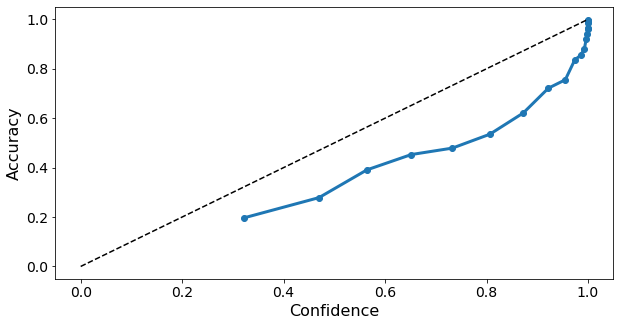

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], "-o", lw=3)
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Confidence", fontsize=16)
plt.plot([0, 1], [0, 1], "--k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Ensembling

Paper: https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf

In [15]:
all_probs = []
for run in range(1, 5):
    checkpoint = torch.load("ckpts/c100/preresnet56/sgd{}/checkpoint-300.pt".format(run))
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    probs, targets = utils.predictions(loaders["test"], model)
    
    all_probs.append(probs)
    
all_probs = np.array(all_probs)

First, let's look at individual models

Accuracy: 0.7379	 NLL: 11208.03515625	 ECE: 0.12393937837779521
Accuracy: 0.7442	 NLL: 11180.4755859375	 ECE: 0.11498497921526434
Accuracy: 0.7517	 NLL: 10659.64453125	 ECE: 0.10826653873920439
Accuracy: 0.7425	 NLL: 11030.255859375	 ECE: 0.11501605789065363


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

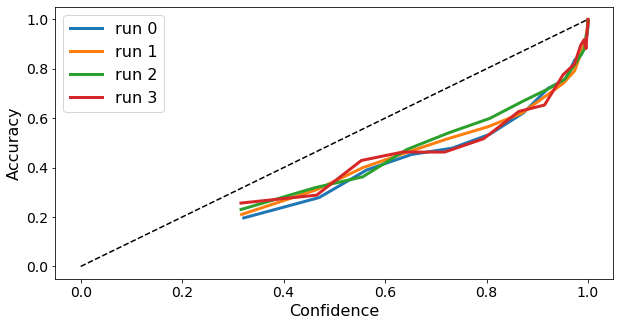

In [17]:
plt.figure(figsize=(10, 5))

for run, probs in enumerate(all_probs):
    preds = np.argmax(probs, axis=-1)
    acc = (preds == targets).mean()
    nll = get_nll(probs, targets)
    calibration_dict = calibration_curve(probs, targets)
    print("Accuracy: {}\t NLL: {}\t ECE: {}".format(acc, nll, calibration_dict["ece"]))
    plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], lw=3, 
             label="run {}".format(run))
    
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Confidence", fontsize=16)
plt.legend(fontsize=16)
plt.plot([0, 1], [0, 1], "--k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Now, let's try to ensemble the models

In [12]:
ens_probs = all_probs.mean(0)

Accuracy: 0.7379	 NLL: 11208.03515625	 ECE: 0.12393937837779521
Accuracy: 0.7442	 NLL: 11180.4755859375	 ECE: 0.11498497921526434
Accuracy: 0.7517	 NLL: 10659.64453125	 ECE: 0.10826653873920439
Accuracy: 0.7425	 NLL: 11030.255859375	 ECE: 0.11501605789065363
*Ensemble*
Accuracy: 0.7919	 NLL: 7680.935546875	 ECE: 0.021088018628954888


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

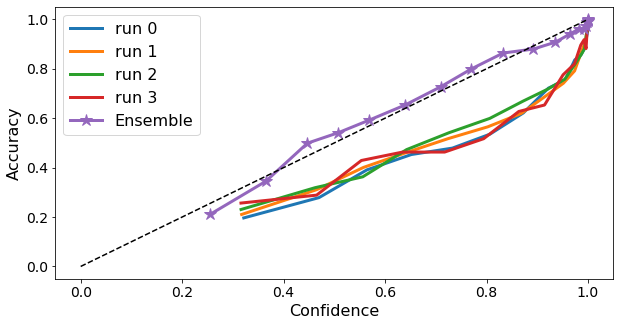

In [13]:
plt.figure(figsize=(10, 5))

for run, probs in enumerate(all_probs):
    preds = np.argmax(probs, axis=-1)
    acc = (preds == targets).mean()
    nll = get_nll(probs, targets)
    calibration_dict = calibration_curve(probs, targets)
    print("Accuracy: {}\t NLL: {}\t ECE: {}".format(acc, nll, calibration_dict["ece"]))
    plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], lw=3, 
             label="run {}".format(run))

#Ensemble
preds = np.argmax(ens_probs, axis=-1)
acc = (preds == targets).mean()
nll = get_nll(ens_probs, targets)
calibration_dict = calibration_curve(ens_probs, targets)
print("*Ensemble*")
print("Accuracy: {}\t NLL: {}\t ECE: {}".format(acc, nll, calibration_dict["ece"]))
plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], "-*", lw=3, 
         markersize=12, label="Ensemble")
    
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Confidence", fontsize=16)
plt.legend(fontsize=16)
plt.plot([0, 1], [0, 1], "--k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Ensemble of $k$ nets $\rightarrow$ $k \times$ compute at both train and test time

## MC-Dropout

- Paper: https://arxiv.org/pdf/1506.02142.pdf
- Blog: http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html

In [18]:
model_cfg = models.PreResNet56Drop
model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model.cuda()
model.eval();

We need to turn dropout back on

In [19]:
checkpoint = torch.load("ckpts/c100/preresnet56/dropout1/checkpoint-300.pt")
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [20]:
def train_dropout(m):
    if type(m) == torch.nn.modules.dropout.Dropout:
        m.train()
        
model.apply(train_dropout);

In [22]:
all_probs = []
for run in range(20):
    
    probs, targets = utils.predictions(loaders["test"], model)
    all_probs.append(probs)
    
all_probs = np.array(all_probs)
dropout_ens_probs = all_probs.mean(0)

Accuracy: 0.7555	 NLL: 10624.99609375	 ECE: 0.11405124507844448
Accuracy: 0.7578	 NLL: 10594.0576171875	 ECE: 0.1111037033230066
Accuracy: 0.7561	 NLL: 10588.7822265625	 ECE: 0.11521591415703299
Accuracy: 0.7553	 NLL: 10525.8544921875	 ECE: 0.11504367900490761
Accuracy: 0.7519	 NLL: 10785.279296875	 ECE: 0.11921191235482695
*Ensemble*
Accuracy: 0.7661	 NLL: 9430.8798828125	 ECE: 0.08339468157887461


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

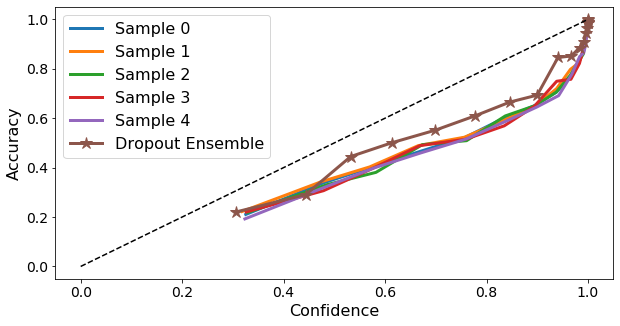

In [23]:
plt.figure(figsize=(10, 5))

for run, probs in enumerate(all_probs[:5]):
    preds = np.argmax(probs, axis=-1)
    acc = (preds == targets).mean()
    nll = get_nll(probs, targets)
    calibration_dict = calibration_curve(probs, targets)
    print("Accuracy: {}\t NLL: {}\t ECE: {}".format(acc, nll, calibration_dict["ece"]))
    plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], lw=3, 
             label="Sample {}".format(run))

#Ensemble
preds = np.argmax(dropout_ens_probs, axis=-1)
acc = (preds == targets).mean()
nll = get_nll(dropout_ens_probs, targets)
calibration_dict = calibration_curve(dropout_ens_probs, targets)
print("*Ensemble*")
print("Accuracy: {}\t NLL: {}\t ECE: {}".format(acc, nll, calibration_dict["ece"]))
plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], "-*", lw=3, 
         markersize=12, label="Dropout Ensemble")
    
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Confidence", fontsize=16)
plt.legend(fontsize=16)
plt.plot([0, 1], [0, 1], "--k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## SWAG

- Paper: https://papers.nips.cc/paper/2019/hash/118921efba23fc329e6560b27861f0c2-Abstract.html
- Slides: https://github.com/wjmaddox/swa_gaussian/blob/master/short_slides.pdf
- Video: https://www.youtube.com/watch?v=5WOj_ZZJ2wM&feature=youtu.be

In [21]:
model_cfg = models.PreResNet56
model = SWAG(
        model_cfg.base,
        no_cov_mat=False,
        max_num_models=20,
        *model_cfg.args,
        num_classes=num_classes,
        **model_cfg.kwargs
    )
model.cuda()
model.eval();

In [22]:
checkpoint = torch.load("ckpts/c100/preresnet56/swag1/swag-300.pt")
model.load_state_dict(checkpoint["state_dict"])

In [40]:
all_probs = []
for run in tqdm.tqdm(range(20)):
    model.sample(scale=.3, cov=True)
    utils.bn_update(loaders["train"], model)
    model.eval()
    probs, targets = utils.predictions(loaders["test"], model)
    all_probs.append(probs)
    
all_probs = np.array(all_probs)
swag_ens_probs = all_probs.mean(0)

100%|██████████| 20/20 [02:21<00:00,  7.10s/it]


Accuracy: 0.7051	 NLL: 10292.2568359375	 ECE: 0.06744039269685746
Accuracy: 0.722	 NLL: 9829.1796875	 ECE: 0.05447430955618621
Accuracy: 0.7123	 NLL: 10195.8515625	 ECE: 0.06207299118936062
Accuracy: 0.7384	 NLL: 9201.3427734375	 ECE: 0.056619151875376694
Accuracy: 0.7112	 NLL: 10079.552734375	 ECE: 0.07044035450369121
*Ensemble*
Accuracy: 0.7678	 NLL: 7818.3447265625	 ECE: 0.021547082453966124


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

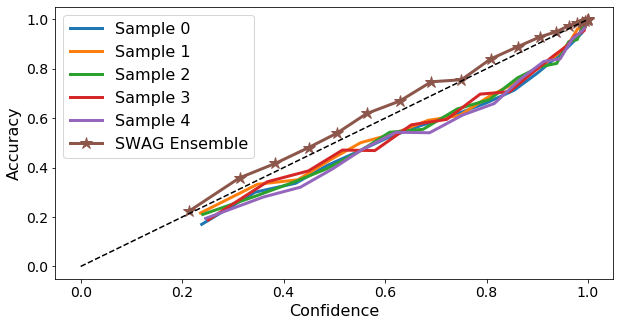

In [41]:
plt.figure(figsize=(10, 5))

for run, probs in enumerate(all_probs[:5]):
    preds = np.argmax(probs, axis=-1)
    acc = (preds == targets).mean()
    nll = get_nll(probs, targets)
    calibration_dict = calibration_curve(probs, targets)
    print("Accuracy: {}\t NLL: {}\t ECE: {}".format(acc, nll, calibration_dict["ece"]))
    plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], lw=3, 
             label="Sample {}".format(run))

#Ensemble
preds = np.argmax(swag_ens_probs, axis=-1)
acc = (preds == targets).mean()
nll = get_nll(swag_ens_probs, targets)
calibration_dict = calibration_curve(swag_ens_probs, targets)
print("*Ensemble*")
print("Accuracy: {}\t NLL: {}\t ECE: {}".format(acc, nll, calibration_dict["ece"]))
plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], "-*", lw=3, 
         markersize=12, label="SWAG Ensemble")
    
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Confidence", fontsize=16)
plt.legend(fontsize=16)
plt.plot([0, 1], [0, 1], "--k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)